In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import yfinance as yf
import os
from pathlib import Path

/tmp/ipykernel_7189/767163670.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Coleta da taxa de retorno risk free

def deannualize(annual_rate, periods=365):
    return (1 + annual_rate) ** (1/periods) - 1

annualized = yf.download("^IRX", start="1995-01-01", end="2023-12-31")["Adj Close"]
daily = annualized.apply(deannualize)

# create dataframe
risk_free_rates = pd.DataFrame({"annualized": annualized, "daily": daily})
risk_free_rates['daily'] = risk_free_rates['daily'] / 100
print(np.shape(risk_free_rates))
risk_free_rates.head()

/home/marcelo/.local/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed

(7282, 2)


,annualized,daily
Date,,
1995-01-03,5.52,0.000051
1995-01-04,5.69,0.000052
1995-01-05,5.71,0.000052
1995-01-06,5.74,0.000052
1995-01-09,5.75,0.000052


In [3]:
# Especificando o caminho padrão do projeto:
pasta = str(Path.cwd().parents[0]) + ("/Clustering/result_clustering/")
pasta

'/mnt/c/Users/MarceloPolecram/Python/MEU_TCC/Clustering/result_clustering/'

In [4]:
operations = pd.read_csv(pasta + "operations_CT.csv")
#operations['Pair'] = operations['Index'].str[:-2]
operations['Pair'] = operations['Ticker 1'] + "-" + operations['Ticker 2']
print(operations.tail())

      Operação  Semestre  Abertura  Fechamento  Dias  Retorno total Ticker 1  \
1108         1        54        95         127    32       0.144190    LOGG3   
1109         1        54       115         127    12      -0.070092    ALPA4   
1110         1        54        26          34     8       0.127489    DXCO3   
1111         2        54       122         127     5       0.021072    DXCO3   
1112         1        54         1          44    43       0.424655    SOMA3   

     Ticker 2  Converged          Index  Retorno total - exp         Pair  
1108    USIM3      False  LOGG3-USIM3-1             1.155103  LOGG3-USIM3  
1109    PDGR3      False  ALPA4-PDGR3-1             0.932308  ALPA4-PDGR3  
1110    POSI3       True  DXCO3-POSI3-1             1.135972  DXCO3-POSI3  
1111    POSI3      False  DXCO3-POSI3-2             1.021295  DXCO3-POSI3  
1112    JHSF3       True  SOMA3-JHSF3-1             1.529063  SOMA3-JHSF3  


In [16]:
operations_by_pair = operations.groupby("Pair").sum("Retorno total")

#print(f"Converged operations: {sum(operations['Converged'])} | Open operations: {np.shape(operations)[0] - sum(operations['Converged'])}")
print(f"Número de operações: {np.shape(operations)[0]}")
print(f"Número de pares: {np.shape(operations_by_pair)[0]}")
print(f"Positive Returns: {sum(operations['Retorno total'] > 0)}\nNegative: {sum(operations['Retorno total'] < 0)}")
print(f"Average trade lenght: {operations['Dias'].mean()}")
print(f"Convergência: {(operations['Converged'].sum()/np.shape(operations)[0])*100} %")
print(f"Highest Return: {round(100*operations['Retorno total'].max(),4)} %")
print(f"Lowest Return: {round(100*operations['Retorno total'].min(),4)} %")
print(f"Average Return: {round(100*operations['Retorno total'].mean(),4)} %")   
print(f"Retorno médio por par: {round(100*operations_by_pair['Retorno total'].mean(),4)} %")
print(f"Retorno médio por par por semestre: {round(np.divide(100*operations_by_pair['Retorno total'].mean(),max(operations['Semestre'])+1),4)} %")

Número de operações: 1113
Número de pares: 702
Positive Returns: 1025
Negative: 78
Average trade lenght: 17.97663971248877
Convergência: 74.66307277628033 %
Highest Return: 166.6977 %
Lowest Return: -35.0555 %
Average Return: 13.2807 %
Retorno médio por par: 21.0562 %
Retorno médio por par por semestre: 0.3828 %


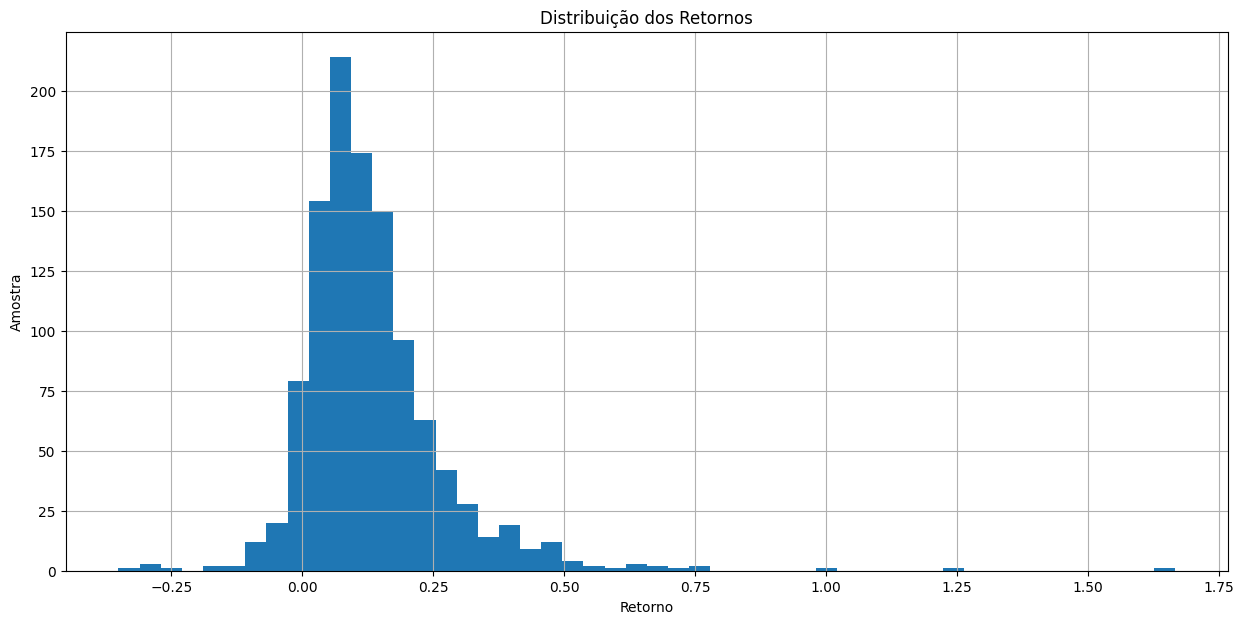

In [6]:
# Return Distribution
fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(1, 1, 1)
operations['Retorno total'].hist(bins=50, ax=ax1)
ax1.set_xlabel('Retorno')
ax1.set_ylabel('Amostra')
ax1.set_title('Distribuição dos Retornos')
plt.show()

Número de pares: 702
Retorno médio por par: 21.0562%
Retorno médio por par por semestre: 0.3828%


In [8]:
# Ações com maior participação
stock_count = {}

for pair in operations_by_pair.index:
    stocks = pair.split("-")
    for stock in stocks:
        if stock in stock_count:
            stock_count[stock] += 1
        else:
            stock_count[stock] = 1
stock_count_df = pd.DataFrame(stock_count.items())
stock_count_df = stock_count_df.sort_values(1)
stock_count_df.to_csv(pasta + "stock_count_20_pairs.csv")
print(stock_count_df)

          0   1
187   CIEL3   1
136   CRFB3   1
138   TCOC4   1
109   RDCD3   1
92   BIDI11   1
..      ...  ..
25    CGAS5  20
168   VIVT3  22
4     BBDC3  22
3     BBAS3  22
30    LIGT3  24

[188 rows x 2 columns]


In [17]:
print("Top pares:")
contagem_nomes = operations['Pair'].value_counts()
print(contagem_nomes.head(5))


Top pares:
Pair
GGBR4-GOAU4    11
ELET3-ELET6     8
PETR4-PETR3     8
VIVT3-CGAS5     7
VALE3-VALE5     6
Name: count, dtype: int64


In [9]:
def rate_interest(principal, final_amount, time):
    rate = (100 * (final_amount/principal)**(1/time)) - 100
    print("Compound interest rate is", rate, "%")

daily_returns = pd.read_csv(pasta + "daily_returns.csv")
daily_returns = daily_returns.iloc[252:,:]
daily_returns = daily_returns / 35
cumulative = np.cumprod(1+daily_returns)
cumulative.plot()
rate_interest(1,cumulative.values[-1],25)

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/c/Users/MarceloPolecram/Python/MEU_TCC/Clustering/result_clustering/daily_returns.csv'

In [ ]:
# Cálculo do Sharpe para o período do estudo
mean_daily_return = daily_returns.values.mean()
print(f"Mean daily return: {mean_daily_return}")
returns_std_dev = daily_returns.values.std()

risk_free_mean = risk_free_rates['daily'].mean()
print(f"Mean risk free return: {risk_free_mean}")

print(f"Fully Invested Sharpe Ratio: {(mean_daily_return - risk_free_mean) / returns_std_dev}")

Rascunho:

In [ ]:
operations['Retorno total'].sum()

In [ ]:
np.sum(daily_returns)

In [ ]:
operations_by_pair

In [ ]:
operations_by_pair['Retorno total'].mean()

In [ ]:
stock_count_df

In [ ]:
max(operations['Semestre'])+1